In [1]:
import matplotlib.pyplot as plt

#
# Plots the evolution of the training accuracy and loss
#
def plot(h,epochs):
    LOSS = 0; ACCURACY = 1
    training = np.zeros((2,epochs)); testing = np.zeros((2,epochs))
    training[LOSS] = h.history['loss']
    testing[LOSS] = h.history['val_loss']    # validation loss
    training[ACCURACY] = h.history['mae']
    testing[ACCURACY] = h.history['val_mae']  # validation accuracy

    epochs = range(1,epochs+1)
    fig, axs = plt.subplots(1,2, figsize=(17,5))
    for i, label in zip((LOSS, ACCURACY),('loss', 'mae')):   
        axs[i].plot(epochs, training[i], 'b-', label='Training ' + label)
        axs[i].plot(epochs, testing[i], 'y-', label='Test ' + label)
        axs[i].set_title('Training and test ' + label)
        axs[i].set_xlabel('Epochs')
        axs[i].set_ylabel(label)
        axs[i].legend()
        axs[i].grid(True)
    plt.show()

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Reads the source dataset
#dataset = pd.read_csv('movielens-ratings1M.txt', header=0, names=['user_id', 'movie_id', 'rating', 'timestamp'])
#dataset = pd.read_csv('filmtrust.txt', delimiter = ' ', header=0, names=['user_id', 'movie_id', 'rating'])
#dataset = pd.read_csv('movielens-ratings10M.txt', delimiter = '::', header=0, names=['user_id', 'movie_id', 'rating', 'timestamp'])
data = pd.read_csv('../MyAnimeList.txt', header=0, delimiter = ';', names=['user_id', 'movie_id', 'rating'])

# Maps the items ID to [1, num_movies]
movie_id_to_new_id = dict()
id = 1
for index, row in data.iterrows():
    if movie_id_to_new_id.get(row['movie_id']) is None:
        movie_id_to_new_id[row['movie_id']] = id
        data.at[index, 'movie_id'] = id
        id += 1
    else:
        data.at[index, 'movie_id'] = movie_id_to_new_id.get(row['movie_id'])

NUM_USERS = len(data.user_id.unique())
NUM_ITEMS = len(data.movie_id.unique())

train, test = train_test_split(data, test_size=0.3,random_state=50)
train = np.array(train)
test = np.array(test)

USER = 0; ITEM = 1; RATING = 2

print ('Number of movies', NUM_ITEMS)
print ('Number of users', NUM_USERS)


Number of movies 2692
Number of users 19179


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 movie-input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 user-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 movie-embedding (Embedding)    (None, 1, 5)         13465       ['movie-input[0][0]']            
                                                                                                  
 user-embedding (Embedding)     (None, 1, 5)         95900       ['user-input[0][0]']             
                                                                                              

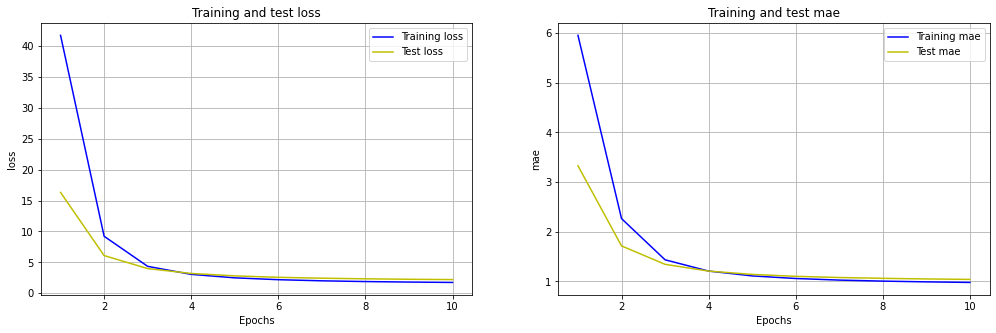

In [3]:
#
# Running DEEPMF to obtain the embedding weights (both users and items)
#
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, Dropout, Dense, Concatenate, Dot
from keras.optimizers import Adam

latent_dim = 5  # 5 neurons in the embedding can adequately code both the user and items

movie_input = Input(shape=[1],name='movie-input')
movie_embedding = Embedding(NUM_ITEMS + 1, latent_dim, name='movie-embedding')(movie_input)
movie_vec = Flatten(name='movie-flatten')(movie_embedding)

user_input = Input(shape=[1],name='user-input')
user_embedding = Embedding(NUM_USERS + 1, latent_dim, name='user-embedding')(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)

dot = Dot(axes=1,name='movie-user-concat')([movie_vec, user_vec])

model_deepMF = Model([user_input, movie_input], dot)
model_deepMF.compile(optimizer='adam', metrics=['mae'], loss='mean_squared_error')

model_deepMF.summary()

EPOCHS = 10
history_deepMF = model_deepMF.fit([train[:,USER],train[:,ITEM]],train[:,RATING], 
                    validation_data=([test[:,USER],test[:,ITEM]], test[:,RATING]), 
                    epochs=EPOCHS, verbose=1)
plot(history_deepMF,EPOCHS)

In [4]:
model_deepMF.save('ModelDeepMF.h5')

In [5]:
from keras.models import Model

# we create two models, from model_deepMF, to get user's and item's embeddings
model_user_embeddings = Model(inputs=user_input, outputs=user_embedding)
model_movie_embeddings = Model(inputs=movie_input, outputs=movie_embedding)

# obtaining all the existing users an items activation maps
user_embeddings = model_user_embeddings.predict(np.array(range(NUM_USERS+1)))
movie_embeddings = model_movie_embeddings.predict(np.array(range(NUM_ITEMS+1)))
    

85/85 [==============================] - 0s 967us/step


In [6]:
import random

#
# creates the dataset of real samples: <user embedding, item embedding, rating>
#
def get_dataset(data):
    embedding_dataset = np.zeros((len(data)+1,latent_dim * 2)) 
    ratings = np.zeros((len(data)+1))
    for i in range(len(data)):
        user_embedding = user_embeddings[int(data[i,USER])][0]
        movie_embedding = movie_embeddings[int(data[i,ITEM])][0]
        ratings[i] = (data[i,RATING]-5.)/10.   # normalized -0.5 to 0.5
        embedding_dataset[i] = np.concatenate((user_embedding, movie_embedding))
    # add ratings
    embedding_dataset = np.insert(embedding_dataset, latent_dim * 2, ratings, axis=1)
    return embedding_dataset

# train and test embeddings and ratings datasets (positive values)
embedding_dataset = get_dataset(np.array(data))

In [7]:
#
# GAN to create the fake samples.
# Both the generator and the discriminator models are really small because the source samples are not
# large and sparse vectors; they are small and dense: 5 real number to code the user, 5 real numbers to 
# code the item and a real number to code the normalized rating.
#
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, Dropout, Dense, Concatenate, Dot, LeakyReLU, BatchNormalization
from keras.optimizers import Adam

class GAN():
    def __init__(self):
        self.latent_dim = latent_dim
        self.noise_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates user
        z = Input(shape=(self.noise_dim,))
        fake_sample = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated users as input and determines validity
        validity = self.discriminator(fake_sample)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()
        model.add(Dense(10, input_dim=self.noise_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(20, input_dim=self.noise_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.2))
        model.add(Dense(self.latent_dim*2+1, activation='linear'))
        model.summary()

        noise = Input(shape=(self.noise_dim,))
        fake_sample = model(noise)

        return Model(noise, fake_sample)

    
    def build_discriminator(self):

        model = Sequential()

        model.add(Dense(4, input_dim=self.latent_dim*2 + 1))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        sample = Input(shape=(self.latent_dim*2 + 1,))
        validity = model(sample)

        return Model(sample, validity)

    
    def train(self, dataset, epochs, batch_size=128, sample_interval=50, num_training_samples=100000):

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of real samples
            idx = np.random.randint(0, num_training_samples, batch_size)
            real_samples = dataset[idx]
           
            noise = np.random.normal(0, 1, (batch_size, self.noise_dim))

            # Generate a batch of fake users
            fake_samples = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(real_samples, valid)
            d_loss_fake = self.discriminator.train_on_batch(fake_samples, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.noise_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            if epoch % sample_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                noise = np.random.normal(0, 1, (1, self.noise_dim))
                

if __name__ == '__main__':
    gan = GAN()
    gan.train(embedding_dataset, epochs=20000, batch_size=32, sample_interval=200, 
              num_training_samples = len(embedding_dataset))
    gan.generator.save('GANRS.h5')
    
    

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 48        
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 53
Trainable params: 53
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 10

1/1 [==============================] - 0s 31ms/step
200 [D loss: 1.107347, acc.: 0.00%] [G loss: 0.387911]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step
400 [D loss: 0.913502, acc.: 50.00%] [G loss: 0.358573]
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 20ms/step
600 [D loss: 0.790157, acc.: 50.00%] [G loss: 0.366021]
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 29ms/step
800 [D loss: 0.667958, acc.: 53.12%] [G loss: 0.578160]
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step
1000 [D loss: 0.540766, acc.: 89.06%] [G loss: 0.801859]
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 21ms/step
1200 [D loss: 0.572060, acc.: 84.38%] [G loss: 0.762830]
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 29ms/step
1400 [D loss: 0.701073, acc.: 54.69%] [G loss: 0.635368]
1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 33ms/step
1600 [D loss: 0.757027, acc.: 57.81%] [G loss: 0.554311]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 26ms/step
1800 [D loss: 0.815047, acc.: 53.12%] [G loss: 0.525919]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step
2000 [D loss: 0.798108, acc.: 6.25%] [G loss: 0.612055]
1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 34ms/step
2200 [D loss: 0.726921, acc.: 40.62%] [G loss: 0.708445]
1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 23ms/step
2400 [D loss: 0.723234, acc.: 46.88%] [G loss: 0.716199]
1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 25ms/step
2600 [D loss: 0.708094, acc.: 50.00%] [G loss: 0.744500]
1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 21ms/step
2800 [D loss: 0.686080, acc.: 50.00%] [G loss: 0.787692]
1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 22ms/step
3000 [D loss: 0.669270, acc.: 50.00%] [G loss: 0.826755]
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 28ms/step
3200 [D loss: 0.665305, acc.: 50.00%] [G loss: 0.826841]
1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step
3400 [D loss: 0.679407, acc.: 50.00%] [G loss: 0.783155]
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 41ms/step
3600 [D loss: 0.695436, acc.: 50.00%] [G loss: 0.765773]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 31ms/step
3800 [D loss: 0.681514, acc.: 50.00%] [G loss: 0.807696]
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 22ms/step
4000 [D loss: 0.677383, acc.: 43.75%] [G loss: 0.801793]
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 25ms/step
4200 [D loss: 0.685649, acc.: 50.00%] [G loss: 0.744114]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step
4400 [D loss: 0.687321, acc.: 48.44%] [G loss: 0.718462]
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 31ms/step
4600 [D loss: 0.692328, acc.: 65.62%] [G loss: 0.692831]
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step
4800 [D loss: 0.691304, acc.: 60.94%] [G loss: 0.711504]
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 32ms/step
5000 [D loss: 0.700027, acc.: 23.44%] [G loss: 0.693956]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 28ms/step
5200 [D loss: 0.693105, acc.: 50.00%] [G loss: 0.719838]
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 26ms/step
5400 [D loss: 0.687188, acc.: 50.00%] [G loss: 0.755298]
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 36ms/step
5600 [D loss: 0.687192, acc.: 50.00%] [G loss: 0.759155]
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 26ms/step
5800 [D loss: 0.686562, acc.: 50.00%] [G loss: 0.750800]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 29ms/step
6000 [D loss: 0.692130, acc.: 48.44%] [G loss: 0.740677]
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 32ms/step
6200 [D loss: 0.693231, acc.: 48.44%] [G loss: 0.725731]
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 28ms/step
6400 [D loss: 0.695219, acc.: 48.44%] [G loss: 0.716842]
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 28ms/step
6600 [D loss: 0.694157, acc.: 50.00%] [G loss: 0.716164]
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 30ms/step
6800 [D loss: 0.691231, acc.: 48.44%] [G loss: 0.721168]
1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 28ms/step
7000 [D loss: 0.689441, acc.: 50.00%] [G loss: 0.726761]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step
7200 [D loss: 0.689943, acc.: 50.00%] [G loss: 0.724250]
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step
7400 [D loss: 0.692861, acc.: 48.44%] [G loss: 0.725356]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 24ms/step
7600 [D loss: 0.692385, acc.: 50.00%] [G loss: 0.719676]
1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 24ms/step
7800 [D loss: 0.692757, acc.: 50.00%] [G loss: 0.716996]
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 27ms/step
8000 [D loss: 0.692698, acc.: 50.00%] [G loss: 0.717825]
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 26ms/step
8200 [D loss: 0.688814, acc.: 50.00%] [G loss: 0.717640]
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step
8400 [D loss: 0.690410, acc.: 46.88%] [G loss: 0.717367]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 27ms/step
8600 [D loss: 0.692035, acc.: 50.00%] [G loss: 0.717165]
1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 19ms/step
8800 [D loss: 0.692986, acc.: 50.00%] [G loss: 0.721254]
1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 20ms/step
9000 [D loss: 0.694560, acc.: 50.00%] [G loss: 0.711993]
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 22ms/step
9200 [D loss: 0.694059, acc.: 50.00%] [G loss: 0.709316]
1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 25ms/step
9400 [D loss: 0.691814, acc.: 50.00%] [G loss: 0.710711]
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 26ms/step
9600 [D loss: 0.691049, acc.: 50.00%] [G loss: 0.706698]
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 23ms/step
9800 [D loss: 0.693364, acc.: 50.00%] [G loss: 0.705282]
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step
10000 [D loss: 0.695363, acc.: 50.00%] [G loss: 0.708472]
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 19ms/step
10200 [D loss: 0.696264, acc.: 50.00%] [G loss: 0.713612]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 27ms/step
10400 [D loss: 0.694297, acc.: 50.00%] [G loss: 0.709759]
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 31ms/step
10600 [D loss: 0.693306, acc.: 40.62%] [G loss: 0.703641]
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 27ms/step
10800 [D loss: 0.691174, acc.: 42.19%] [G loss: 0.699669]
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step
11000 [D loss: 0.692996, acc.: 48.44%] [G loss: 0.701392]
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 19ms/step
11200 [D loss: 0.694125, acc.: 50.00%] [G loss: 0.708834]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step
11400 [D loss: 0.695554, acc.: 50.00%] [G loss: 0.708929]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 29ms/step
11600 [D loss: 0.692993, acc.: 50.00%] [G loss: 0.705648]
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 25ms/step
11800 [D loss: 0.691447, acc.: 46.88%] [G loss: 0.698337]
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step
12000 [D loss: 0.691299, acc.: 45.31%] [G loss: 0.697306]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step
12200 [D loss: 0.695220, acc.: 40.62%] [G loss: 0.696780]
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 26ms/step
12400 [D loss: 0.695639, acc.: 48.44%] [G loss: 0.700983]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step
12600 [D loss: 0.692924, acc.: 50.00%] [G loss: 0.702977]
1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 29ms/step
12800 [D loss: 0.691599, acc.: 50.00%] [G loss: 0.706743]
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 20ms/step
13000 [D loss: 0.692581, acc.: 46.88%] [G loss: 0.702253]
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 25ms/step
13200 [D loss: 0.694901, acc.: 26.56%] [G loss: 0.693547]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 27ms/step
13400 [D loss: 0.694747, acc.: 45.31%] [G loss: 0.697783]
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 29ms/step
13600 [D loss: 0.691870, acc.: 50.00%] [G loss: 0.706724]
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 22ms/step
13800 [D loss: 0.692192, acc.: 48.44%] [G loss: 0.700972]
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step
14000 [D loss: 0.693669, acc.: 64.06%] [G loss: 0.693223]
1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step
14200 [D loss: 0.696377, acc.: 9.38%] [G loss: 0.688998]
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 25ms/step
14400 [D loss: 0.693163, acc.: 50.00%] [G loss: 0.700683]
1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 25ms/step
14600 [D loss: 0.691368, acc.: 50.00%] [G loss: 0.704353]
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 40ms/step
14800 [D loss: 0.692524, acc.: 50.00%] [G loss: 0.701053]
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 19ms/step
15000 [D loss: 0.695426, acc.: 20.31%] [G loss: 0.693879]
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step
15200 [D loss: 0.695290, acc.: 26.56%] [G loss: 0.692617]
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step
15400 [D loss: 0.691072, acc.: 50.00%] [G loss: 0.702220]
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 25ms/step
15600 [D loss: 0.691805, acc.: 46.88%] [G loss: 0.699990]
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step
15800 [D loss: 0.694793, acc.: 15.62%] [G loss: 0.692151]
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 36ms/step
16000 [D loss: 0.696276, acc.: 1.56%] [G loss: 0.689558]
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step
16200 [D loss: 0.691696, acc.: 50.00%] [G loss: 0.700613]
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 25ms/step
16400 [D loss: 0.691911, acc.: 50.00%] [G loss: 0.701919]
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 21ms/step
16600 [D loss: 0.694223, acc.: 39.06%] [G loss: 0.696740]
1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step
16800 [D loss: 0.695559, acc.: 14.06%] [G loss: 0.691894]
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 29ms/step
17000 [D loss: 0.692445, acc.: 50.00%] [G loss: 0.696421]
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 24ms/step
17200 [D loss: 0.691390, acc.: 46.88%] [G loss: 0.699170]
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 20ms/step
17400 [D loss: 0.692878, acc.: 53.12%] [G loss: 0.692891]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 28ms/step
17600 [D loss: 0.695695, acc.: 48.44%] [G loss: 0.688786]
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 37ms/step
17800 [D loss: 0.692275, acc.: 50.00%] [G loss: 0.698773]
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step
18000 [D loss: 0.691406, acc.: 50.00%] [G loss: 0.700862]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step
18200 [D loss: 0.693671, acc.: 31.25%] [G loss: 0.694465]
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step
18400 [D loss: 0.695066, acc.: 20.31%] [G loss: 0.692926]
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 22ms/step
18600 [D loss: 0.692231, acc.: 50.00%] [G loss: 0.698802]
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 22ms/step
18800 [D loss: 0.692212, acc.: 73.44%] [G loss: 0.695610]
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 29ms/step
19000 [D loss: 0.693869, acc.: 56.25%] [G loss: 0.688037]
1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 28ms/step
19200 [D loss: 0.695677, acc.: 6.25%] [G loss: 0.690984]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step
19400 [D loss: 0.691605, acc.: 50.00%] [G loss: 0.700127]
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step
19600 [D loss: 0.692152, acc.: 43.75%] [G loss: 0.698596]
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step
19800 [D loss: 0.694364, acc.: 20.31%] [G loss: 0.691146]
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 23ms/step


In [18]:
from keras.models import load_model
import statistics
import numpy as np

############
# creates augmented samples in the format:
# embedding user, embedding item and rating vectors

FAKE_SAMPLES = 150000  # number of generated fake samples

def get_augmented(model, num_fake_samples):
    STD_DEV = 0.4 # You can stablish the fake samples variability by setting this value (usually
    # in the range [0.2..2.0])
    noise = np.random.normal(0, STD_DEV, (num_fake_samples, gan.noise_dim))
    fake_samples = model.predict(noise)   
    return fake_samples
 
augmented = get_augmented(load_model('GANRS.h5'), FAKE_SAMPLES)

# Normalizes the ratings distribution
y = augmented[:,-1]
mu_aug = statistics.mean(y)
de_aug = statistics.stdev(y, mu_aug)

mu = statistics.mean(embedding_dataset[:,-1])
de = statistics.stdev(embedding_dataset[:,-1], mu)
print(mu, de)
   
augmented[:,-1] *= mu / mu_aug
mu = statistics.mean(augmented[:,-1])
de = statistics.stdev(augmented[:,-1], mu)
print(mu, de)

4688/4688 [==============================] - 5s 1ms/step
0.2769903848080331 0.1558338546105953
0.27699038 0.24306524136592653


In [19]:
from sklearn.cluster import KMeans

# We can create 'families of datasets' containing combinations of number of users and items
# This sklearn kMeans process can be slow when the number of users or items is high.
testing_users = [500,1000,2000]
testing_items = [500,1000]

for K in testing_users:   
    clustering_users = KMeans(n_clusters=K, n_init=1, max_iter= 100, verbose=1)
    cluster_users = clustering_users.fit_predict(augmented[:FAKE_SAMPLES,:latent_dim])  
    np.save('cluster_users' + str(FAKE_SAMPLES) + '_' + str(K), cluster_users)  
    print("end cluster users: " + str(K))

for K in testing_items:   
    clustering_items = KMeans(n_clusters=K, n_init=1, max_iter= 100, verbose=1)
    cluster_items = clustering_items.fit_predict(augmented[:FAKE_SAMPLES,latent_dim:-1])  
    np.save('cluster_items' + str(FAKE_SAMPLES) + '_' + str(K), cluster_items)   
    print("end cluster items: " + str(K))

Initialization complete
Iteration 0, inertia 3608.71337890625
Iteration 1, inertia 3306.374267578125
Iteration 2, inertia 3234.267822265625
Iteration 3, inertia 3199.559326171875
Iteration 4, inertia 3177.29541015625
Iteration 5, inertia 3160.8251953125
Iteration 6, inertia 3148.210693359375
Iteration 7, inertia 3138.60595703125
Iteration 8, inertia 3130.767578125
Iteration 9, inertia 3124.37646484375
Iteration 10, inertia 3118.718017578125
Iteration 11, inertia 3114.09765625
Iteration 12, inertia 3109.965576171875
Iteration 13, inertia 3106.42822265625
Iteration 14, inertia 3103.361572265625
Iteration 15, inertia 3100.6064453125
Iteration 16, inertia 3098.200439453125
Iteration 17, inertia 3095.97607421875
Iteration 18, inertia 3093.96435546875
Iteration 19, inertia 3092.211669921875
Iteration 20, inertia 3090.513916015625
Iteration 21, inertia 3088.90673828125
Iteration 22, inertia 3087.468994140625
Iteration 23, inertia 3086.294677734375
Iteration 24, inertia 3085.217529296875
Itera

Iteration 7, inertia 1690.028564453125
Iteration 8, inertia 1685.7254638671875
Iteration 9, inertia 1682.4066162109375
Iteration 10, inertia 1679.717529296875
Iteration 11, inertia 1677.431884765625
Iteration 12, inertia 1675.381591796875
Iteration 13, inertia 1673.585693359375
Iteration 14, inertia 1672.03955078125
Iteration 15, inertia 1670.646728515625
Iteration 16, inertia 1669.4007568359375
Iteration 17, inertia 1668.173583984375
Iteration 18, inertia 1667.2490234375
Iteration 19, inertia 1666.468017578125
Iteration 20, inertia 1665.7548828125
Iteration 21, inertia 1665.132568359375
Iteration 22, inertia 1664.5645751953125
Iteration 23, inertia 1664.0247802734375
Iteration 24, inertia 1663.5238037109375
Iteration 25, inertia 1663.029052734375
Iteration 26, inertia 1662.5782470703125
Iteration 27, inertia 1662.1434326171875
Iteration 28, inertia 1661.7828369140625
Iteration 29, inertia 1661.40478515625
Iteration 30, inertia 1661.0523681640625
Iteration 31, inertia 1660.72119140625


Iteration 41, inertia 6304.11328125
Iteration 42, inertia 6303.61572265625
Iteration 43, inertia 6302.98583984375
Iteration 44, inertia 6302.3798828125
Iteration 45, inertia 6301.8603515625
Iteration 46, inertia 6301.35595703125
Iteration 47, inertia 6300.8388671875
Iteration 48, inertia 6300.435546875
Iteration 49, inertia 6300.095703125
Iteration 50, inertia 6299.74365234375
Iteration 51, inertia 6299.47607421875
Iteration 52, inertia 6299.072265625
Iteration 53, inertia 6298.767578125
Iteration 54, inertia 6298.498046875
Iteration 55, inertia 6298.20458984375
Iteration 56, inertia 6297.947265625
Iteration 57, inertia 6297.6904296875
Iteration 58, inertia 6297.4521484375
Iteration 59, inertia 6297.205078125
Iteration 60, inertia 6297.0
Iteration 61, inertia 6296.82958984375
Iteration 62, inertia 6296.5712890625
Iteration 63, inertia 6296.36376953125
Iteration 64, inertia 6296.22412109375
Iteration 65, inertia 6296.09521484375
Iteration 66, inertia 6295.98779296875
Iteration 67, inert

In [23]:
#
# Writing syntetic datasets
#
for Ku in testing_users:
    cluster_users = np.load('cluster_users' + str(FAKE_SAMPLES) + '_' + str(Ku)+'.npy')
    for Ki in testing_items:
        cluster_items = np.load('cluster_items' + str(FAKE_SAMPLES) + '_' + str(Ki)+'.npy')
        f = open ('synthetic_'+str(FAKE_SAMPLES)+'_'+str(Ku)+'_'+str(Ki)+'.txt','w')
        f.write('user,item,rating\n')
        for i in range(FAKE_SAMPLES):
            us = str(cluster_users[i])
            it = str(cluster_items[i])
            ra = augmented[i,-1:][0]*10. + 5.  # from normalized [[-0.5..0.5] to [0..10]]
            # ratings quantization
            if ra > 10.:
                ra = 10
            elif ra < 1:
                ra = 1
            else:
                ra = np.round(ra)
            f.write(us + "," + it + "," + str(ra) + "\n")
        f.close()
        print("synthetic dataset " + str(Ku) + ', ' + str(Ki) + " has been created")
      

synthetic dataset 500, 500 has been created
synthetic dataset 500, 1000 has been created
synthetic dataset 1000, 500 has been created
synthetic dataset 1000, 1000 has been created
synthetic dataset 2000, 500 has been created
synthetic dataset 2000, 1000 has been created


In [24]:
#
# We remove duplicated samples and also samples where the same user votes more than 2 ratings to the same item
#

SEPARATOR = ","
sizes = np.zeros((len(testing_users),len(testing_items)))
for i,Ku in enumerate(testing_users):
    for j,Ki in enumerate(testing_items):
        file = 'synthetic_'+str(FAKE_SAMPLES)+'_'+str(Ku)+'_'+str(Ki)+'.txt'
        data = np.array(pd.read_csv(file, sep=SEPARATOR, header=1))
        df = pd.DataFrame(data)
        df = df.drop_duplicates()
        
        df.to_csv(file, index=False, header=['user','item','rating'])  
        
        # remove samples where the same user votes more than 2 ratings to the same item
        tuples_to_remove = []
        for (user, item), group in df.groupby(by=[0,1]):
            if len(group)>=3:
                tuples_to_remove.extend(group.index.tolist())
        df.drop(tuples_to_remove, inplace=True)
        sizes[i][j] = len(df) 
        print(file, len(df)) 
        df.to_csv(file, index=False, header=['user','item','rating'])  
        np.save('synthetic_'+str(FAKE_SAMPLES)+'_SIZES', sizes)      
print('datasets sizes: \n', sizes)

synthetic_150000_500_500.txt 26577
synthetic_150000_500_1000.txt 40580
synthetic_150000_1000_500.txt 41018
synthetic_150000_1000_1000.txt 57221
synthetic_150000_2000_500.txt 58054
synthetic_150000_2000_1000.txt 74489
datasets sizes:  [[26577. 40580.]
 [41018. 57221.]
 [58054. 74489.]]
